## 0. 라이브러리 / 기본셋업

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = './data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

Wall time: 4.58 s


## 1.1 기본적인 내용 파악

정리하면,   
+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.   
특성 별로 자세히 살펴봅시다.

### 특성의 기본 정보

In [4]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


### 피쳐별 고유 갯수

In [5]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


### 피쳐 이름 변경

In [6]:
#testId -> testID
df.columns = ['userID', 'assessmentItemID', 'testID', 'answerCode', 'Timestamp',
       'KnowledgeTag']

In [63]:
def percentile(s):
    return np.sum(s) / len(s)

# 1.문제집(testID) 관련

### 1.1 문제집별 문항 갯수 분포
- 문제집 별 고유문항 수는 최소 2개에서 최대 12개를 가지고 있음
- 제일 많은 것은 5개

In [92]:
test_ass = df.groupby('testID')['assessmentItemID'].nunique().reset_index()
print('총 문제집 개수 :',np.sum(test_ass['assessmentItemID']))
print(test_ass)

총 문제집 개수 : 9454
          testID  assessmentItemID
0     A010000001                 5
1     A010000002                 5
2     A010000003                 5
3     A010000004                 5
4     A010000005                 5
...          ...               ...
1532  A090000070                 8
1533  A090000071                 8
1534  A090000072                 6
1535  A090000073                 6
1536  A090000074                 6

[1537 rows x 2 columns]


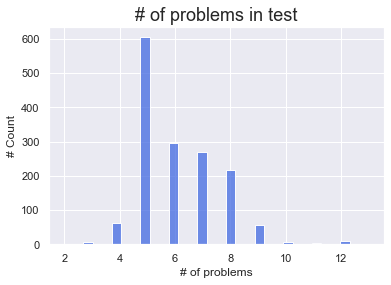

In [90]:
fig, ax = plt.subplots()
sns.histplot(data = test_ass, x = 'assessmentItemID', ax = ax, color="royalblue")
ax.set_xlabel('# of problems')
ax.set_ylabel('# Count')
ax.set_title('# of problems in test',fontsize="18")
# ax.set_xticks(range(len(test_ass['assessmentItemID'].unique())))
plt.show()

### 1.2 문제집별 정답률 
- 문제집의 최고 정답률 : 95.55, 최소 정답률 : 32.72, 정답률 평균 : 66.79

In [64]:
test_groupby = df.groupby('testID').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


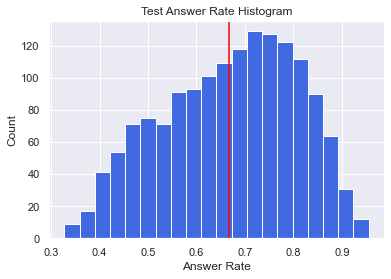

In [107]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20,color = 'royalblue')
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

# 2. 유저 관련 EDA

### 2.1 유저별로 몇개의 문항을 풀었는지
- 학생이 제일 많이 푼 문항은 1860개, 제일 적은 문항은 9개 

In [108]:
df.groupby(['userID'])['assessmentItemID'].count().describe()

count    6698.000000
mean      338.397432
std       321.331429
min         9.000000
25%        78.000000
50%       231.500000
75%       513.000000
max      1860.000000
Name: assessmentItemID, dtype: float64

Text(0.5, 1.0, '# of Questions - Answer Rate')

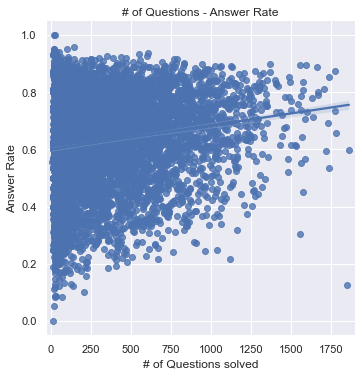

In [109]:
user_ass = df.groupby('userID').agg({'assessmentItemID' : 'count' , 'answerCode': percentile})
g = sns.lmplot(data = user_ass,x = 'assessmentItemID', y = 'answerCode')
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [110]:
user_ass.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


### 2.2 유저/문제집

문제집을 최소 2개는 풀어봄, 최대 300개 풀어본 유저도 있다

In [111]:
user_test_nq = df.groupby('userID')[['testID']].nunique()

In [160]:
user_test_nq

,testID
userID,
0,104
1,153
2,48
5,119
6,169
...,...
7436,3
7437,3
7438,3


In [157]:
user_test_ans = df.groupby('userID').agg({'answerCode': percentile})

In [159]:
user_test_ans

,answerCode
userID,
0,0.630872
1,0.853162
2,0.612319
5,0.795918
6,0.442997
...,...
7436,0.466667
7437,0.375000
7438,0.750000


In [168]:
testid_ans.corr()

,key_0,testID,answerCode
key_0,1.000000,-0.801831,-0.166004
testID,-0.801831,1.000000,0.211643
answerCode,-0.166004,0.211643,1.000000


<AxesSubplot:xlabel='testID'>

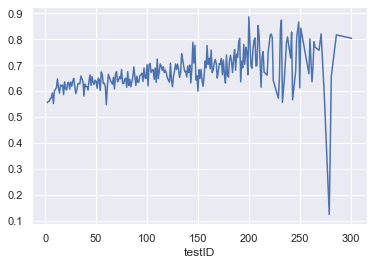

In [166]:
testid_ans = user_test_nq.merge(user_test_ans, on =user_test_nq.index)
testid_ans.groupby('testID')['answerCode'].mean().plot()

In [164]:
testid_ans

,key_0,testID,answerCode
0,0,104,0.630872
1,1,153,0.853162
2,2,48,0.612319
3,5,119,0.795918
4,6,169,0.442997
...,...,...,...
6693,7436,3,0.466667
6694,7437,3,0.375000
6695,7438,3,0.750000
6696,7440,3,0.400000


### 유저가 푼 문제집 수 대비 정답률
- 문제집을 많이 풀 수록 정답률이 올라가는 경향을 보이는데 특정 문제집 수에서 매우 낮은 정답률 분포를 가짐
- 문제집 279개를 푼 유저가 있는데 정답률 평균이 0.12밖에 안된다 -> 한명의 유저가 279개의 문제집을 풀었는데 정답률이 0.12??
- 푼 문제집을 구간화하여 피쳐만들기 -> 누적 문제집으로 해야할듯?

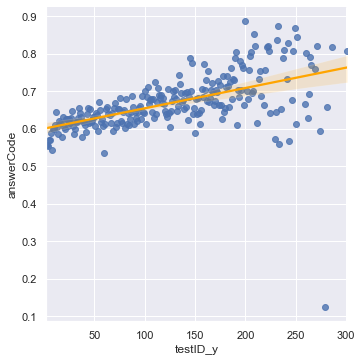

In [219]:
user_test_nq = df.groupby('userID')[['testID']].nunique()
testid_ans = df.merge(user_test_nq,on = 'userID')
testid_ans_mean = df.merge(user_test_nq,on = 'userID').groupby('testID_y')[['answerCode']].mean().reset_index()
sns.lmplot(data = testid_ans_mean , x = 'testID_y',y='answerCode',line_kws={"color": "orange"})

In [117]:
testid_ans_mean

,testID_y,answerCode
0,2,0.555556
1,3,0.556114
2,4,0.554010
3,5,0.568391
4,6,0.570538
...,...,...
242,274,0.594642
243,279,0.124526
244,281,0.656162
245,286,0.818047


In [116]:
testid_ans_mean.corr()['answerCode']['testID_y']

0.5358880582192541

In [118]:
print(f"푼 문제집의 수와 퍙균 정답률 사이 상관관계: {testid_ans_mean.corr()['answerCode']['testID_y']:.3f}")

푼 문제집의 수와 퍙균 정답률 사이 상관관계: 0.536


In [25]:
testid_ans[testid_ans['문제집_y'] == 279]

,유저,문항,문제집_x,정답,시간,태그,문제집_y
354395,481,A070003001,A070000003,0,2020-03-01 02:47:37,3793,279
354396,481,A070003002,A070000003,0,2020-03-01 02:47:43,3793,279
354397,481,A070003003,A070000003,0,2020-03-01 02:47:46,3793,279
354398,481,A070003004,A070000003,1,2020-03-01 02:47:50,117,279
354399,481,A070003005,A070000003,0,2020-03-01 02:47:53,3792,279
...,...,...,...,...,...,...,...
356237,481,A070130004,A070000130,1,2020-12-29 02:08:36,9069,279
356238,481,A070130005,A070000130,0,2020-12-29 02:08:40,9067,279
356239,481,A070130006,A070000130,0,2020-12-29 02:08:43,9069,279
356240,481,A070130007,A070000130,1,2020-12-29 02:08:45,9070,279


### 2.4 유저의 누적으로 푼 횟수/합
- 문제를 맞출수록 정답률의 평균이 올라가는 것을 알 수 있다?

In [113]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']

In [114]:
test = df.copy()
test['test'] =_cumsum
test.groupby('test')['answerCode'].mean().reset_index().corr()

,test,answerCode
test,1.000000,0.751329
answerCode,0.751329,1.000000


In [117]:
print(f"누적으로 푼 문항의 수와 평균 정답률 사이 상관관계: {test.groupby('test')['answerCode'].mean().reset_index().corr()['answerCode']['test']:.3f}")

누적으로 푼 문항의 수와 평균 정답률 사이 상관관계: 0.751


### 2.4 유저/시간
- 새로운 문제집을 푸는 경우 푼 시간이 엄청나게 크게 기록됨 -> 30분 이상 푼 것들은 새로운 문제집을 시작한 것으로 판단하여 0으로 처리(85% 넘게 30분 이하로 풀림) 

In [180]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

In [181]:
df['elapsed'].quantile(0.85)

1579.0

In [182]:
df['elapsed_new'] = df['elapsed'].apply(lambda x: 0 if x>= 1800 else x)

In [222]:
df.drop('elapsed',inplace = True,axis=1)

In [207]:
d = df.groupby('elapsed_new')[['answerCode']].mean().reset_index()
d

,elapsed_new,answerCode
0,0.0,0.737768
1,1.0,0.246893
2,2.0,0.227417
3,3.0,0.229280
4,4.0,0.248611
...,...,...
1795,1795.0,0.727273
1796,1796.0,0.666667
1797,1797.0,0.785714
1798,1798.0,0.555556


Text(0.5, 1.0, '# time of answer')

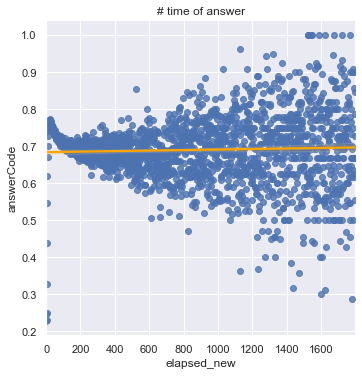

In [218]:
sns.lmplot(data = d, x= 'elapsed_new', y = 'answerCode',line_kws={"color": "orange"})
ax = plt.gca()
ax.set_title('# time of answer')

# 3. 문항 관련

In [223]:
df

,userID,assessmentItemID,testID,answerCode,Timestamp,KnowledgeTag,elapsed_new
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0


### 3.1 문항별 정답률

In [224]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


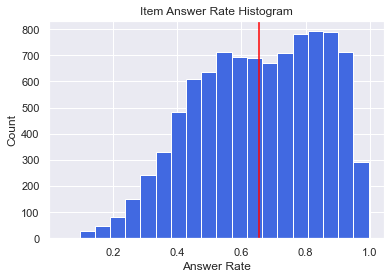

In [226]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20,color = 'royalblue')
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

### 3.2 문항번호 정답률
- 문항번호가 뒤로 갈수록 정답률이 낮아짐
- 대분류가 의미가 있다는 뜻?

In [241]:
prob_groupby_r = prob_groupby.reset_index().reset_index()
prob_groupby_r

,index,assessmentItemID,userID,answerCode
0,0,A010001001,317,0.930599
1,1,A010001002,317,0.958991
2,2,A010001003,317,0.905363
3,3,A010001004,317,0.949527
4,4,A010001005,317,0.886435
...,...,...,...,...
9449,9449,A090074002,45,0.444444
9450,9450,A090074003,45,0.577778
9451,9451,A090074004,45,0.333333
9452,9452,A090074005,45,0.400000


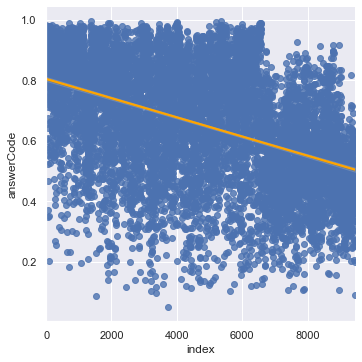

In [249]:
sns.lmplot(data = prob_groupby_r, x = 'index' , y = 'answerCode',line_kws={"color": "orange"})

### 3.3 문항별  푸는데 걸린 시간
- 대부분 30~100초의 시간으로 문제를 풂

In [265]:
time_mean = df.groupby('assessmentItemID').agg({'elapsed_new' : 'mean'})

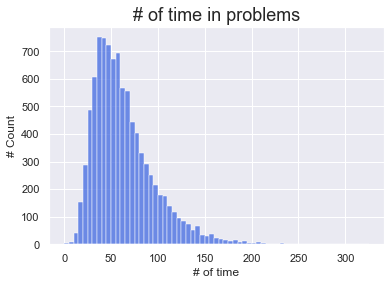

In [275]:
fig, ax = plt.subplots()
sns.histplot(time_mean['elapsed_new'], binwidth=5, color="royalblue")
ax.set_xlabel('# of time')
ax.set_ylabel('# Count')
ax.set_title('# of time in problems',fontsize="18")
plt.show()

# 4. 태그별 관련

### 4.1 태그별 정답률
- 많이 풀린 태그가 정답률이 높음

In [277]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby

,userID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


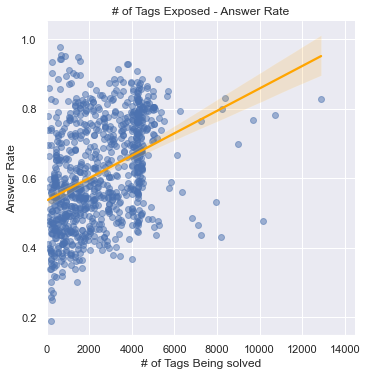

In [272]:
g = sns.lmplot(
    data=tag_groupby,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate');

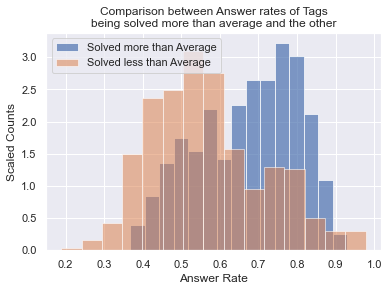

In [276]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average'
)
ax.legend()

### 4.2 태그번호 정답률
- 태그번호에 따른 정답률 차이는 없는 듯

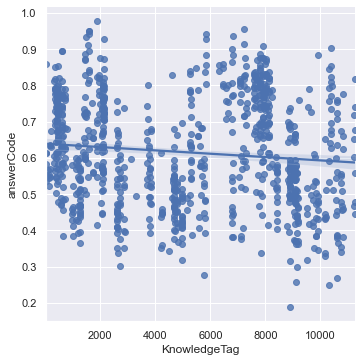

In [281]:
tag = tag_groupby.reset_index()
sns.lmplot(data = tag , x= 'KnowledgeTag',y = 'answerCode')

### 4.3 태그별 문제푸는 시간
- 태그별로도 푸는시간은 40~80초로 비슷함

In [283]:
time_tag_mean = df.groupby('KnowledgeTag').agg({'elapsed_new' : 'mean'})

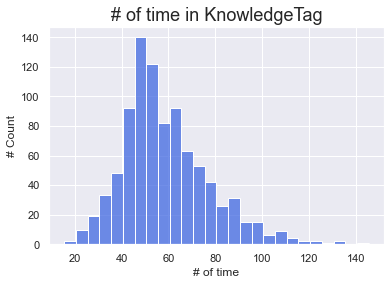

In [285]:
fig, ax = plt.subplots()
sns.histplot(time_tag_mean['elapsed_new'], binwidth=5, color="royalblue")
ax.set_xlabel('# of time')
ax.set_ylabel('# Count')
ax.set_title('# of time in KnowledgeTag',fontsize="18")
plt.show()

# 5. 대분류

In [288]:
df['class'] = df['assessmentItemID'].apply(lambda x : x[2])

In [290]:
df

,userID,assessmentItemID,testID,answerCode,Timestamp,KnowledgeTag,elapsed_new,class
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,6
...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0,3
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.0,4
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0,4
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0,4


### 5.1 대분류별 정답률 분포

In [296]:
class_groupby = df.groupby('class').agg({
    'userID': 'count',
    'answerCode': percentile
}).reset_index()
class_groupby

,class,userID,answerCode
0,1,272082,0.800876
1,2,268327,0.737593
2,3,273762,0.702238
3,4,267323,0.684056
4,5,275773,0.658208
5,6,264434,0.709232
6,7,279164,0.521876
7,8,246336,0.502598
8,9,119385,0.449948


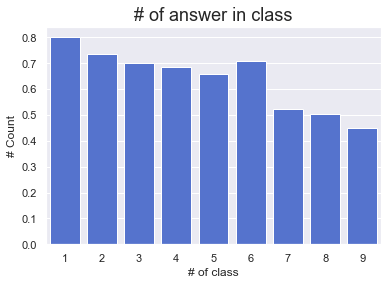

In [301]:
fig, ax = plt.subplots()
sns.barplot(data = class_groupby, x = 'class', y = 'answerCode', color = 'royalblue')
ax.set_xlabel('# of class')
ax.set_ylabel('# Count')
ax.set_title('# of answer in class',fontsize="18")
plt.show()

### 5.2 대분류별 푼 유저수

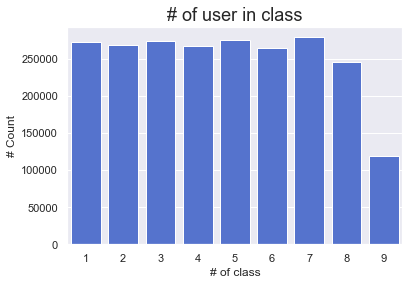

In [304]:
fig, ax = plt.subplots()
sns.barplot(data = class_groupby, x = 'class', y = 'userID', color = 'royalblue')
ax.set_xlabel('# of class')
ax.set_ylabel('# Count')
ax.set_title('# of user in class',fontsize="18")
plt.show()

### 5.3 대분류별 푸는데 걸린시간

In [313]:
time_class_mean = df.groupby('class').agg({'elapsed_new' : 'mean'}).reset_index()

In [318]:
time_class_mean

,class,elapsed_new
0,1,60.074540
1,2,64.743201
2,3,63.204170
3,4,63.430449
4,5,70.533435
5,6,67.047029
6,7,58.118608
7,8,51.558286
8,9,45.929522


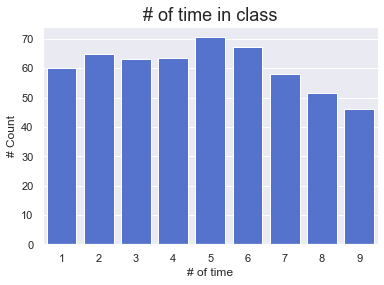

In [319]:
fig, ax = plt.subplots()
sns.barplot(data = time_class_mean, x = 'class',y = 'elapsed_new', color="royalblue")
ax.set_xlabel('# of time')
ax.set_ylabel('# Count')
ax.set_title('# of time in class',fontsize="18")
plt.show()

<AxesSubplot:xlabel='elapsed_new', ylabel='Count'>

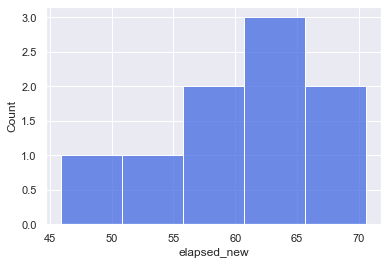

In [321]:
sns.histplot(time_class_mean['elapsed_new'], color="royalblue")